# 🚀 Access curated PNW Dataset with SeisBench APIs


![image](https://github.com/niyiyu/PNW-ML/blob/main/figures/README_overview.png?raw=true)

**Author:** Yiyu Ni  
**Goal:** This notebook demonstrates how to access the curated PNW seismic dataset with SeisBench APIs.

---

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seisbench.data as sbd
import seisbench.generate as sbg

## 1. Load the dataset

A dataset is made by the waveform file (in `hdf5` format, sometime also called `h5`) and the perspective metadata file (in `csv` format). See the structure in the `data/pnwml` folder with two small datasets (i.e., **miniPNW** and **mesoPNW**).

🚀 Read more about SeisBench data format: https://seisbench.readthedocs.io/en/stable/pages/data_format.html

In [2]:
! tree -lh ../data/pnwml

[ 160]  ../data/pnwml
├── [ 128]  mesoPNW
│   ├── [4.7M]  metadata.csv
│   └── [6.3G]  waveforms.hdf5
└── [ 160]  miniPNW
    ├── [424K]  metadata.csv
    └── [640M]  waveforms.hdf5

2 directories, 4 files


The `waveforms.hdf5` contains arrays of seismograms. We can see arrays are grouped into 10 buckets. The file also contains very few metadata like the `component_order` for three-component seismogram.

🛠️ `h5dump` is a useful tool to check the hierarchical structure of this HDF5 file.

In [3]:
! h5dump -n ../data/pnwml/mesoPNW/waveforms.hdf5

HDF5 "../data/pnwml/mesoPNW/waveforms.hdf5" {
FILE_CONTENTS {
 group      /
 group      /data
 dataset    /data/bucket1
 dataset    /data/bucket10
 dataset    /data/bucket2
 dataset    /data/bucket3
 dataset    /data/bucket4
 dataset    /data/bucket5
 dataset    /data/bucket6
 dataset    /data/bucket7
 dataset    /data/bucket8
 dataset    /data/bucket9
 group      /data_format
 dataset    /data_format/component_order
 }
}


The `metadata.csv` represents a table of metadata for each data sample. It also documents where to locate the waveform. We will have a better view of this table later.

In [4]:
! head -n 5 ../data/pnwml/mesoPNW/metadata.csv

event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,source_horizontal_uncertainty_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_arrival_uncertainty_s,trace_P_arrival_uncertainty_s,trace_P_polarity,trace_S_onset,trace_P_onset,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,bucket,tindex
uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.52,earthquake,14.907,2.1,md,0.03,1.68,0.694,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket4$0,:3,:15001",100,2002-10-03T01

We can load the dataset using `seisbench.data` as a `WaveformDataset` class. 

In [5]:
dataset = sbd.WaveformDataset("../data/pnwml/mesoPNW/")

print(f"The dataset contains {len(dataset)} samples.")

2025-04-23 21:41:11,945 | seisbench | WARNING | Dimension order not specified in data set. Assuming CW.


The dataset contains 18640 samples.


The metadata can be accessed by the `.metadata` attribute of the dataset as a `pd.DataFrame` object.

In [6]:
pd.set_option('display.max_columns', None) # show all columns
meta = dataset.metadata
meta.head()

,index,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,source_horizontal_uncertainty_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_arrival_uncertainty_s,trace_P_arrival_uncertainty_s,trace_P_polarity,trace_S_onset,trace_P_onset,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,bucket,tindex,trace_chunk,trace_component_order
0,0,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,0.694,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket4$0,:3,:15001",100.0,2002-10-03T01:55:59.530000Z,8097,6733,0.04,0.02,undecidable,NaN,NaN,6.135|3.065|11.766,eq,NaN,NaN,2.1,0.03,NaN,0,1,4,0,,ENZ
1,1,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,0.694,UW,EH,RPW,--,48.448,-121.515,850.0,"bucket9$0,:3,:15001",100.0,2002-10-03T01:55:59.530000Z,7258,6238,0.04,0.01,undecidable,NaN,NaN,nan|nan|22.583,eq,NaN,NaN,2.1,0.03,NaN,2,0,9,0,,ENZ
2,2,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,0.694,UW,BH,SQM,--,48.074,-123.048,45.0,"bucket4$1,:3,:15001",100.0,2002-10-03T01:55:59.530000Z,7037,6113,0.08,0.04,undecidable,NaN,NaN,1.756|3.057|3.551,eq,NaN,NaN,2.1,0.03,NaN,0,1,4,1,,ENZ
3,3,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,0.694,UW,EH,MCW,--,48.679,-122.833,693.0,"bucket7$0,:3,:15001",100.0,2002-10-03T01:55:59.530000Z,5894,5442,0.04,0.01,negative,NaN,NaN,nan|nan|27.185,eq,NaN,NaN,2.1,0.03,NaN,2,0,7,0,,ENZ
4,4,uw10568748,2002-09-26T07:00:04.860000Z,48.481,-123.133,earthquake,22.748,2.9,md,0.03,0.91,0.672,UW,HH,SP2,--,47.556,-122.249,30.0,"bucket3$0,:3,:15001",100.0,2002-09-26T06:59:14.860000Z,8647,6948,0.04,0.01,negative,NaN,NaN,10.881|17.107|2.242,eq,NaN,NaN,2.9,0.03,NaN,0,1,3,0,,ENZ


## 2. SeisBench APIs for data access and augmentataion

A generator is employed as a dataset wrapper, where users specify APIs for data pre-processing and augmentation. 

🚀 See https://seisbench.readthedocs.io/en/latest/pages/documentation/generate.html for all supported augmentation methods.

In [7]:
generator = sbg.GenericGenerator(dataset)

phase_dict = {"trace_P_arrival_sample": "P",
              "trace_S_arrival_sample": "S"}

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), 
                           samples_before=5000, 
                           windowlen=10000, 
                           selection="first", 
                           strategy="pad"),
    sbg.RandomWindow(windowlen=6000),
    sbg.Normalize(demean_axis=-1, 
                  amp_norm_axis=-1, 
                  amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.DetectionLabeller("trace_P_arrival_sample", 
                          "trace_S_arrival_sample", 
                          factor=1.,
                          dim=0, 
                          key=('X', 'y2')),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, 
                              shape='triangle', 
                              sigma=10, 
                              dim=0, 
                              key=('X', 'y1'))
]
generator.add_augmentations(augmentations)
print(generator)

<class 'seisbench.generate.generator.GenericGenerator'> with 6 augmentations:
 1.	WindowAroundSample (metadata_keys=['trace_P_arrival_sample', 'trace_S_arrival_sample'], samples_before=5000, selection=first)
 2.	RandomWindow (low=None, high=None)
 3.	Normalize (Demean (axis=-1), Amplitude normalization (type=peak, axis=-1))
 4.	ChangeDtype (dtype=<class 'numpy.float32'>, key=('X', 'X'))
 5.	DetectionLabeller (label_type=multi_class, dim=0)
 6.	ProbabilisticLabeller (label_type=multi_class, dim=0)



**A generator is indexable.** You can use an index to access a specific data sample, and plot the waveforms.

In [8]:
idx = 101
sp = generator[idx]
for k, v in sp.items():
    print({k: v})
    print({k: v.shape})
    print("===============")

{'X': array([[ 0.00743013, -0.056532  , -0.07826877, ..., -0.02479234,
        -0.05956911, -0.0431165 ],
       [-0.03419543, -0.03570489, -0.02515121, ...,  0.02853432,
         0.01560807, -0.00841141],
       [ 0.05039116,  0.0543057 ,  0.05657212, ...,  0.06317093,
         0.0874832 ,  0.08027197]], dtype=float32)}
{'X': (3, 6000)}
{'y2': array([[0., 0., 0., ..., 1., 1., 1.]])}
{'y2': (1, 6000)}
{'y1': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])}
{'y1': (3, 6000)}


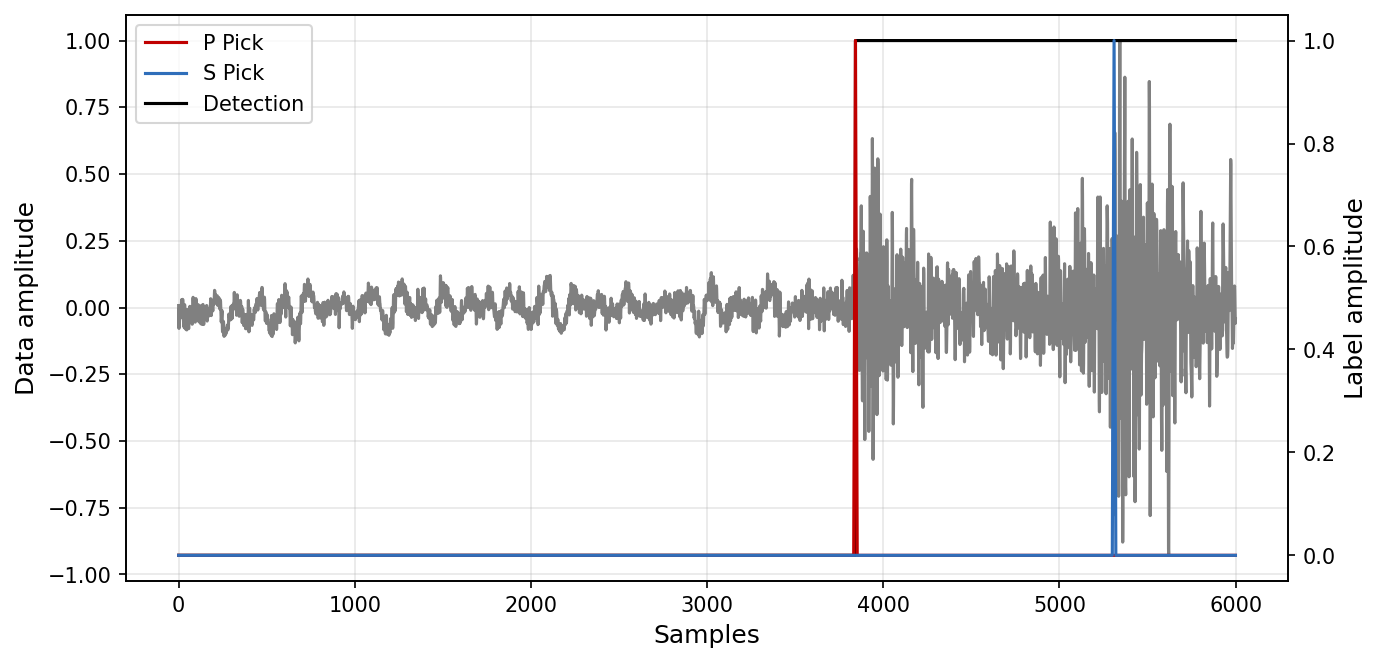

In [9]:
plt.figure(figsize = (10, 5), dpi = 150)
plt.plot(sp['X'][0, :].T, c='gray')
plt.xlabel("Samples", fontsize = 12)
plt.ylabel("Data amplitude", fontsize = 12)
plt.grid(True, alpha=0.3)

ax = plt.gca().twinx()
ax.plot(sp['y1'][0, :].T, label = "P Pick", c="#c00000")
ax.plot(sp['y1'][1, :].T, label = "S Pick", c="#2f6eba")
ax.plot(sp['y2'][0, :].T, label = "Detection", color='k', zorder=-1)
plt.ylabel("Label amplitude", fontsize = 12)

plt.legend(loc = 'upper left')

## 3. Loading data in batch

Machine Learning model training usually load data in batch. The `generator` object can be wrapped by the pytorch API `torch.utils.data.DataLoader` to generate samples in batch. See examples below that creates a data loader and return 256 samples in batch.

In [10]:
batch_size = 256
loader = torch.utils.data.DataLoader(generator, 
                    batch_size=batch_size, shuffle=True, num_workers=0)

See the changes in the **array sizez** as well as the **array type**.

In [11]:
for i in loader:
    for k, v in i.items():
        print({k: v})
        print({k: v.shape})
        print("===============")
    break

{'X': tensor([[[-0.3553, -0.3545, -0.3528,  ..., -0.1436, -0.1028, -0.0371],
         [ 0.1409,  0.1364,  0.1332,  ..., -0.0967, -0.0943, -0.0863],
         [-0.1704, -0.1658, -0.1625,  ...,  0.3062,  0.3093,  0.3049]],

        [[-0.1790, -0.1660, -0.1899,  ...,  0.1565, -0.0152, -0.1217],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.0510, -0.0510, -0.0304,  ...,  0.0722,  0.1003,  0.0997],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0411,  0.0343,  0.0308,  ...,  0.1134,  0.1103,  0.1096],
         [-0.0015, -0.0034, -0.0053,  ...,  0.0106,  0.0076,  0.0048],
         [-0.0312, -0.0308, -0.0346,  ...,  0.0256,  0.0235,  0.0219]],

        [[ 0.0196, -0.0742, -0.0818,  ..., -0.0292,  0.0280,  0.0524],
         [ 0.0552,  0.0740,  0.0378,  ...,  0.049

## Reference

* https://github.com/niyiyu/PNW-ML
* Ni, Y., Hutko, A., Skene, F., Denolle, M., Malone, S., Bodin, P., Hartog, R., & Wright, A. (2023). Curated Pacific Northwest AI-ready Seismic Dataset. Seismica, 2(1). https://doi.org/10.26443/seismica.v2i1.368
* Woollam, J., Münchmeyer, J., Tilmann, F., Rietbrock, A., Lange, D., Bornstein, T., ... & Soto, H. (2022). SeisBench—A toolbox for machine learning in seismology. Seismological Society of America, 93(3), 1695-1709.